In [9]:
minmaxInterval = 2000

## open port

In [10]:
!echo 'quzinee1!'| sudo -S chmod a+rw /dev/ttyUSB0

[sudo] password for terry: 

## BASIC USAGE OF XL320 CLASS

In [11]:
import rospy
from trajectory_msgs.msg import JointTrajectory, JointTrajectoryPoint

rospy.init_node("Experiment3")

class Soro(object):
    def __init__(self):
        self.transform_data_pub = rospy.Publisher('/dynamixel/control', JointTrajectory, queue_size=10)

    def actuate(self, data:JointTrajectory):
        self.transform_data_pub.publish(data)

soro = Soro()
rate = rospy.Rate(1) # 10 Hz

In [12]:
import sys
sys.path.append(".")
""" FOR DYNAMIXEL """
from model.class_xc330 import xc330
""" FOR MODERN DRIVER """
import roslib; roslib.load_manifest('ur_driver')
import rospy
import actionlib
from control_msgs.msg import *
from trajectory_msgs.msg import *
from sensor_msgs.msg import JointState

import copy
import numpy as np

from numpy import pi as PI
DEG90 = PI/2

class UR(object):
    def __init__(self,):
        self.JOINT_NAMES = ['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint',
                            'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
        self.client      = None
        
   
    def move_arm_speed(self, traj:JointTrajectory, speed_limit):
        joint_pos1 = rospy.wait_for_message("joint_states", JointState).position
        rospy.sleep(0.1)
        joint_pos2 = rospy.wait_for_message("joint_states", JointState).position

        diff = np.linalg.norm(joint_pos2 - joint_pos1)
        assert diff < 1e-5
        
        try: 
            g = FollowJointTrajectoryGoal()
            g.trajectory = copy.deepcopy(traj)
            g.trajectory.joint_names = self.JOINT_NAMES
            joint_states = rospy.wait_for_message("joint_states", JointState)
            joints_pos   = joint_states.position

            init_point = JointTrajectoryPoint()
            init_point.positions = joints_pos
            init_point.time_from_start = rospy.Duration.from_sec(0)
            init_point.velocities = [0 for _ in range(6)]
            g.trajectory.points.insert(0, init_point)

            q_list = []
            time_list = []
            for point in g.trajectory.points:
                q_list.append(point.positions)
                time_list.append(point.time_from_start.to_sec())

            print(q_list)

            for i in range(len(q_list)-1):
                q_before = np.array(q_list[i])
                q_after  = np.array(q_list[i+1])
                print(q_after, q_before)
                time_before = time_list[i]
                time_after = time_list[i+1]

                diff_q = q_after - q_before
                diff_time = time_after - time_before

                speed = np.linalg.norm(diff_q)/diff_time
                print(speed)
                assert speed <= speed_limit
            
            

            self.client.send_goal(g)
            # self.client.wait_for_result()
        except KeyboardInterrupt:
            self.client.cancel_goal()
            raise
        except:
            raise  

    def execute_arm_speed(self, traj, speed_limit):
        try:
            self.client = actionlib.SimpleActionClient('follow_joint_trajectory', FollowJointTrajectoryAction)
            print("Waiting for server...")
            self.client.wait_for_server()
            print("Connected to server")
            """ Initialize """
            self.move_arm_speed(traj, speed_limit)
            print("Finish plan")

        except KeyboardInterrupt:
            rospy.signal_shutdown("KeyboardInterrupt")
            raise      

    def execute_arm_time(self, joints, movetime):
        try:
            self.client = actionlib.SimpleActionClient('follow_joint_trajectory', FollowJointTrajectoryAction)
            print("Waiting for server...")
            self.client.wait_for_server()
            print("Connected to server")
            """ Initialize """
            self.move_arm_time(joints, movetime)
            print("Finish plan")

        except KeyboardInterrupt:
            rospy.signal_shutdown("KeyboardInterrupt")
            raise      


## INSTANTIATE Robot 

In [13]:
robot = UR()
init_joint =[0,-DEG90,DEG90,-DEG90,-DEG90, DEG90]

In [14]:
cature_q = np.array([-90, -90, 90, 90, 55, 0], dtype=np.float32) / 180 * PI

q = cature_q
q_traj = JointTrajectory()

point = JointTrajectoryPoint()
point.positions = q
point.velocities = [0 for _ in range(6)]
point.time_from_start = rospy.Duration.from_sec(20)

q_traj.points.append(point)


motor_traj = JointTrajectory()
point = JointTrajectoryPoint()
point.positions = [0 for _ in range(8)]
point.time_from_start = rospy.Duration.from_sec(20)
motor_traj.points.append(point)

CAPTURE = True

if CAPTURE:
    robot.execute_arm_speed(q_traj, speed_limit=0.5)
    soro.actuate(motor_traj)


Waiting for server...
Connected to server
[(-1.5708096663104456, -1.5707468551448365, 1.5707958380328577, 1.5707942682453613, 0.9599196910858154, -2.7004872457325746e-05), array([-1.5707964, -1.5707964,  1.5707964,  1.5707964,  0.9599311,
        0.       ], dtype=float32)]
[-1.5707964 -1.5707964  1.5707964  1.5707964  0.9599311  0.       ] [-1.57080967e+00 -1.57074686e+00  1.57079584e+00  1.57079427e+00
  9.59919691e-01 -2.70048725e-05]
2.9547090131163178e-06
Finish plan


# Capture Target Object

In [17]:
import subprocess
import os

if CAPTURE:
    if os.path.exists("../UnseenObjectClustering/label_data.npy"):
        os.remove("../UnseenObjectClustering/label_data.npy")

    if os.path.exists("../UnseenObjectClustering/depth_data.npy"):
        os.remove("../UnseenObjectClustering/depth_data.npy")

    subprocess.run(["cd ../UnseenObjectClustering; ./experiments/scripts/ros_seg_rgbd_add_test_segmentation_realsense.sh $GPU_ID 0"], shell=True)

+ set -e
+ export PYTHONUNBUFFERED=True
+ PYTHONUNBUFFERED=True
+ export CUDA_VISIBLE_DEVICES=0
+ CUDA_VISIBLE_DEVICES=0
+ outdir=data/checkpoints
+ ./ros/test_images_segmentation.py --gpu 0 --network seg_resnet34_8s_embedding --pretrained data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_sampling_epoch_16.checkpoint.pth --pretrained_crop data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_crop_sampling_epoch_16.checkpoint.pth --cfg experiments/cfgs/seg_resnet34_8s_embedding_cosine_rgbd_add_tabletop.yml


Called with args:
Namespace(background_name=None, cfg_file='experiments/cfgs/seg_resnet34_8s_embedding_cosine_rgbd_add_tabletop.yml', dataset_name='shapenet_scene_train', gpu_id=0, instance_id=0, network_name='seg_resnet34_8s_embedding', pretrained='data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_sampling_epoch_16.checkpoint.pth', pretrained_crop='data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_crop_sampling_epoch_16.checkpoint.pth', randomize=False)
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'BACKGROUND': '',
 'CAD': '',
 'DATA_PATH': '',
 'EPS': 1e-14,
 'EXP_DIR': 'tabletop_object',
 'FEATURE_STRIDE': 16,
 'FLIP_X': False,
 'FLOW_HEIGHT': 512,
 'FLOW_WIDTH': 640,
 'GPU_ID': 0,
 'INPUT': 'RGBD',
 'INTRINSICS': [],
 'MODE': 'TRAIN',
 'NETWORK': 'VGG16',
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POSE': '',
 'RIG': '',
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/terry/Rilab/sOftrobot/UnseenObjectClustering',
 'TEST': {'AL

/home/terry/.local/lib/python3.8/site-packages/torch/nn/functional.py:4037: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


0 objects
num_object 0


/home/terry/.local/lib/python3.8/site-packages/torch/nn/functional.py:3982: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


1 objects
num_object 1


In [1]:
import numpy as np
label_pixel = np.load('../UnseenObjectClustering/label_data.npy')
depth_pixel = np.load('../UnseenObjectClustering/depth_data.npy') 

In [2]:
def Rotation_X(rad):
    roll = np.array([[1, 	       0, 	      0,    0],
             		 [0, np.cos(rad), -np.sin(rad), 0],
             		 [0, np.sin(rad),  np.cos(rad), 0],
             		 [0,		   0,	      0,    0]])
    return roll 


def Rotation_Y(rad):
    pitch = np.array([[np.cos(rad), 0, np.sin(rad), 0],
              		  [0,		    1, 	         0, 0],
              		  [-np.sin(rad),0, np.cos(rad), 0],
              		  [0, 		    0, 	         0, 0]])
    return pitch


def Rotation_Z(rad):
    yaw = np.array([[np.cos(rad), -np.sin(rad),  0, 0],
         	        [np.sin(rad),  np.cos(rad),  0, 0],
              		[0, 			         0,  1, 0],
             		[0, 			         0,  0, 0]])
    return yaw 

def Translation(x , y, z):
    Position = np.array([[0, 0, 0, x],
                         [0, 0, 0, y],
                         [0, 0, 0, z],
                         [0, 0, 0, 1]])
    return Position


def HT_matrix(Rotation, Position):
    Homogeneous_Transform = Rotation + Position
    return Homogeneous_Transform


In [6]:
import math

# Calibration
rotation_x   = Rotation_X(-math.pi)
rotation_y   = Rotation_Y(-math.pi/180*55)
rotation_mat = np.dot(rotation_x, rotation_y)

camera_p = np.load("planned_traj/camera_p.npy")

position_mat = Translation(*(camera_p.tolist()))
transform_mat= HT_matrix(rotation_mat, position_mat)

camera_p

array([ 0.33107886, -0.25199999,  1.08883276])

In [4]:
def camera_to_base(transform_mat, points):
    ones = np.ones((len(points),1))
    points = np.concatenate((points,ones),axis=1)
    t_points = points.T
    t_transformed_ponints = np.dot(transform_mat,t_points)
    transformed_ponints = t_transformed_ponints.T
    xyz = transformed_ponints[:,0:3]
    return xyz


def rgb_to_float(color):
    """ Converts an RGB list to the packed float format used by PCL
    
        From the PCL docs:
        "Due to historical reasons (PCL was first developed as a ROS package),
         the RGB information is packed into an integer and casted to a float"
    
        Args:
            color (list): 3-element list of integers [0-255,0-255,0-255]
            
        Returns:
            float_rgb: RGB value packed as a float
    """
    hex_r = (0xff & color[0]) << 16
    hex_g = (0xff & color[1]) << 8
    hex_b = (0xff & color[2])

    hex_rgb = hex_r | hex_g | hex_b

    float_rgb = struct.unpack('f', struct.pack('i', hex_rgb))[0]

    return float_rgb

In [5]:
clustering_num=len(np.unique(label_pixel));target_cluster_center_point=None;cluster_cen_pose_lst = []
# Total cluster loop
for cluster_idx in range(clustering_num):
    
    
    if cluster_idx ==0: continue

    # Random color 
    # color = random_color_gen()
    cluster_xlst, cluster_ylst = np.where(label_pixel==cluster_idx)

    clusters = []
    for idx, (x,y,z) in enumerate(zip(depth_pixel[2,cluster_xlst, cluster_ylst], \
                                        depth_pixel[0,cluster_xlst, cluster_ylst], \
                                        depth_pixel[1,cluster_xlst, cluster_ylst])):
        position=camera_to_base(transform_mat, np.array([[x,y,z]])).reshape(-1)
        clusters.append(position)

    break
        
single_cluster = np.stack(clusters)


In [23]:
import numpy as np

# assume point_cloud is the point cloud as a numpy array with shape (n_points, 3)

single_cluster = single_cluster[:,:3]
# calculate the median of each dimension
medians = np.median(single_cluster, axis=0)

# calculate the median absolute deviation (MAD) of each dimension
mad = np.median(np.abs(single_cluster - medians), axis=0)

# set a threshold for outliers based on the MAD
threshold = 3.0 * mad

# calculate the distance of each point from the medians
distances = np.abs(single_cluster - medians)

# identify the outliers by comparing the distances to the threshold
outliers = np.any(distances > threshold, axis=1)

# remove the outliers from the point cloud
cleaned_point_cloud = single_cluster[~outliers]

# cleaned_point_cloud = single_cluster

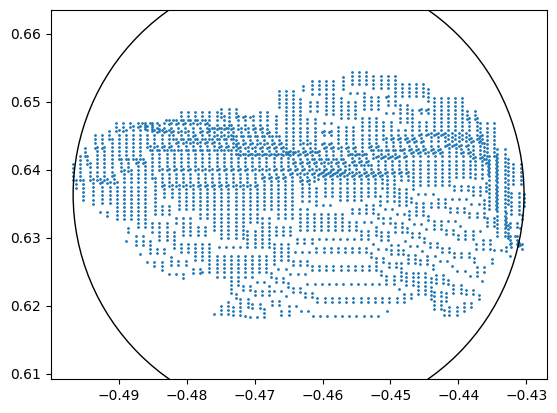

0.6643609470018901

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# assume cleaned_point_cloud is the cleaned point cloud as a numpy array with shape (n_points, 3)

# project points onto the XY plane by ignoring the Z coordinate
projected_points = cleaned_point_cloud[:, [1,2]]

# compute extent of points in XY plane
min_x, min_y = np.min(projected_points, axis=0)
max_x, max_y = np.max(projected_points, axis=0)

# compute center of circle
center_x, center_y = (min_x + max_x) / 2, (min_y + max_y) / 2

# compute radius of circle
radius = max((max_x - min_x), (max_y - min_y)) / 2

# plot the circle and points
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(projected_points[:, 0], projected_points[:, 1], s=1)
circle = plt.Circle((center_x, center_y), radius, fill=False)
ax.add_artist(circle)

edge = 0.02
plt.xlim(center_x-radius-edge, center_x+radius+edge)
plt.ylim(center_y-radius-edge, center_y+radius+edge)
plt.axis('equal')
plt.show()


z_down = max_y + 0.01

z_down

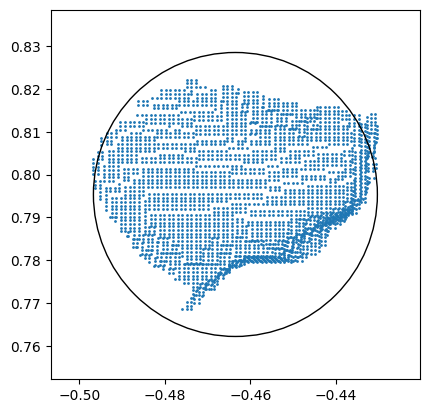

(-0.4635172212339958,
 0.795338988935087,
 0.6643609470018901,
 0.033162012696266174)

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# assume cleaned_point_cloud is the cleaned point cloud as a numpy array with shape (n_points, 3)

# project points onto the XY plane by ignoring the Z coordinate
projected_points = cleaned_point_cloud[:, [1,0]]

# compute extent of points in XY plane
min_x, min_y = np.min(projected_points, axis=0)
max_x, max_y = np.max(projected_points, axis=0)

# compute center of circle
center_x, center_y = (min_x + max_x) / 2, (min_y + max_y) / 2

# compute radius of circle
radius = (max_x - min_x)/ 2
# plot the circle and points
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(projected_points[:, 0], projected_points[:, 1], s=1)
circle = plt.Circle((center_x, center_y), radius, fill=False)
ax.add_artist(circle)

edge = 0.01
plt.xlim(center_x-radius-edge, center_x+radius+edge)
plt.ylim(center_y-radius-edge, center_y+radius+edge)
# plt.axis('equal')
plt.show()



# print(f"position_target:{position_target}")
center_position_array = np.array([center_x,center_y, z_down])

center_x, center_y, z_down, radius

In [116]:
np.save("planned_traj/bottle/center_position.npy", center_position_array)

# Move Caputre Pose

In [117]:
cature_q = np.array([-90, -90, 90, 90, 55, 0], dtype=np.float32) / 180 * PI

q = cature_q
q_traj = JointTrajectory()

point = JointTrajectoryPoint()
point.positions = q
point.velocities = [0 for _ in range(6)]
point.time_from_start = rospy.Duration.from_sec(20)

q_traj.points.append(point)


motor_traj = JointTrajectory()
point = JointTrajectoryPoint()
point.positions = [0 for _ in range(8)]
point.time_from_start = rospy.Duration.from_sec(20)
motor_traj.points.append(point)

MOVECAPTURE = True

if MOVECAPTURE:
    robot.execute_arm_speed(q_traj, speed_limit=0.5)
    soro.actuate(motor_traj)

robot.client.wait_for_result()

Waiting for server...
Connected to server
[(-0.3627870718585413, -1.1440814298442383, 1.3418663183795374, -1.768832346002096, -1.5707739035235804, -1.1480210463153284), array([-1.5707964, -1.5707964,  1.5707964,  1.5707964,  0.9599311,
        0.       ], dtype=float32)]
[-1.5707964 -1.5707964  1.5707964  1.5707964  0.9599311  0.       ] [-0.36278707 -1.14408143  1.34186632 -1.76883235 -1.5707739  -1.14802105]
0.22676706690514395
Finish plan


True

# Deploy Planned Trajectory

In [114]:
runname = "bottle_open"
motor_array = np.load(f"planned_traj/{runname}/motor_array.npy")
qs_array = np.load(f"planned_traj/{runname}/qs_array.npy")

temp = motor_array.copy()

temp[:,0] = -motor_array[:,1]
temp[:,1] = -motor_array[:,0]


motor_array = temp

motor_array.shape, qs_array.shape, motor_array, qs_array

((12, 2),
 (12, 6),
 array([[  -89.06826,   269.87808],
        [  725.1785 ,   895.4042 ],
        [ -427.62335, -1721.0647 ],
        [-1579.6631 , -1599.3783 ],
        [-1460.0404 , -1485.0001 ],
        [-1667.1816 ,  -841.87897],
        [-1804.1301 ,  -206.66121],
        [-1810.6615 ,   442.43137],
        [-1845.0419 ,   508.6358 ],
        [-2039.6921 ,   698.3498 ],
        [-2227.5195 ,   702.9408 ],
        [-1459.7756 ,  1415.6869 ]], dtype=float32),
 array([[-0.36498833, -1.180541  ,  1.1702825 , -1.5605423 , -1.5707968 ,
         -0.36498734],
        [-0.3671921 , -1.158706  ,  1.3394396 , -1.7514814 , -1.5707793 ,
         -0.3671916 ],
        [-0.3673176 , -1.16222   ,  1.3650244 , -1.7737505 , -1.570771  ,
         -0.36732468],
        [-0.3638994 , -1.1556178 ,  1.3724684 , -1.7877069 , -1.5708717 ,
         -0.36393633],
        [-0.3653655 , -1.1531001 ,  1.3673086 , -1.7851146 , -1.5708852 ,
         -0.36540103],
        [-0.36380917, -1.1534251 ,  1.3550317 

In [115]:
q_traj = JointTrajectory()
motor_traj = JointTrajectory()

q_before = np.array(rospy.wait_for_message("joint_states", JointState).position)
motor_before = np.array([0 for _ in range(2)])
unit_time = 1
track_time = 0

            
for i,(qs, motor_control) in enumerate(zip(qs_array, motor_array)):
    if i in [0,1,2,12,13]:
        unit_time = 3
    else:
        unit_time = 1.0
    
    delta_q = np.linalg.norm(qs - q_before)
    delta_motor = np.linalg.norm(motor_control - motor_before)


    unit_time = max(delta_q/0.2, unit_time)
    
    if unit_time < delta_motor/3000:
        print(i)
        print(unit_time)
        print(delta_motor/3000)
    unit_time = max(delta_motor/3000, unit_time)


    track_time = track_time + unit_time
    point = JointTrajectoryPoint()
    point.positions = qs
    point.velocities = [0 for _ in range(6)]
    point.time_from_start = rospy.Duration.from_sec(track_time)
    q_traj.points.append(point)
    
    point = JointTrajectoryPoint()
    point.positions = np.tile(motor_control, (4)).tolist()
    point.velocities = [0 for _ in range(8)]
    point.time_from_start = rospy.Duration.from_sec(track_time)
    motor_traj.points.append(point)

    q_before = qs

q_last = qs.copy()
motor_last = motor_control.copy()

robot.execute_arm_speed(q_traj, speed_limit=0.5)
soro.actuate(motor_traj)

Waiting for server...
Connected to server
[(-1.5708096663104456, -1.5708066425719203, 1.5707843939410608, 1.57086627065625, 0.9600155353546143, 9.059906005859375e-06), array([-0.36498833, -1.180541  ,  1.1702825 , -1.5605423 , -1.5707968 ,
       -0.36498734], dtype=float32), array([-0.3671921, -1.158706 ,  1.3394396, -1.7514814, -1.5707793,
       -0.3671916], dtype=float32), array([-0.3673176 , -1.16222   ,  1.3650244 , -1.7737505 , -1.570771  ,
       -0.36732468], dtype=float32), array([-0.3638994 , -1.1556178 ,  1.3724684 , -1.7877069 , -1.5708717 ,
       -0.36393633], dtype=float32), array([-0.3653655 , -1.1531001 ,  1.3673086 , -1.7851146 , -1.5708852 ,
       -0.36540103], dtype=float32), array([-0.36380917, -1.1534251 ,  1.3550317 , -1.7723552 , -1.5708979 ,
       -0.62376595], dtype=float32), array([-0.36400568, -1.1544499 ,  1.350932  , -1.767228  , -1.5709058 ,
       -0.88574827], dtype=float32), array([-0.36423835, -1.15447   ,  1.3492646 , -1.7655374 , -1.5709039 ,
   

# Repeat

In [87]:
q_traj = JointTrajectory()
motor_traj = JointTrajectory()

q_before = np.array(rospy.wait_for_message("joint_states", JointState).position)
motor_before = np.array([0 for _ in range(2)])
unit_time = 1
track_time = 0


for i,(qs, motor_control) in enumerate(zip(qs_array, motor_array)):
    if i ==0:
        qs = q_last
        motor_control = motor_last
        
    if i in [len(qs_array)-1]: continue
    
    if i in [0,1,2,12,13]:
        unit_time = 3
    else:
        unit_time = 1.0
    
    delta_q = np.linalg.norm(qs - q_before)
    delta_motor = np.linalg.norm(motor_control - motor_before)


    unit_time = max(delta_q/0.2, unit_time)
    
    if unit_time < delta_motor/3000:
        print(i)
        print(unit_time)
        print(delta_motor/3000)
    unit_time = max(delta_motor/3000, unit_time)


    track_time = track_time + unit_time
    point = JointTrajectoryPoint()
    point.positions = qs
    point.velocities = [0 for _ in range(6)]
    point.time_from_start = rospy.Duration.from_sec(track_time)
    q_traj.points.append(point)
    
    point = JointTrajectoryPoint()
    point.positions = np.tile(motor_control, (4)).tolist()
    point.velocities = [0 for _ in range(8)]
    point.time_from_start = rospy.Duration.from_sec(track_time)
    motor_traj.points.append(point)

    q_before = qs

import time

robot.execute_arm_speed(q_traj, speed_limit=0.5)
soro.actuate(motor_traj)
robot.client.wait_for_result()
time.sleep(1)

Waiting for server...
Connected to server
[(-0.3649237791644495, -1.1575393241694947, 1.363619629536764, -1.77673401455068, -1.5708578268634241, -1.1502774397479456), array([-0.36281532, -1.1443001 ,  1.3421736 , -1.7689242 , -1.5707568 ,
       -1.148068  ], dtype=float32), array([-0.3671921, -1.158706 ,  1.3394396, -1.7514814, -1.5707793,
       -0.3671916], dtype=float32), array([-0.3673176 , -1.16222   ,  1.3650244 , -1.7737505 , -1.570771  ,
       -0.36732468], dtype=float32), array([-0.3638994 , -1.1556178 ,  1.3724684 , -1.7877069 , -1.5708717 ,
       -0.36393633], dtype=float32), array([-0.3653655 , -1.1531001 ,  1.3673086 , -1.7851146 , -1.5708852 ,
       -0.36540103], dtype=float32), array([-0.36380917, -1.1534251 ,  1.3550317 , -1.7723552 , -1.5708979 ,
       -0.62376595], dtype=float32), array([-0.36400568, -1.1544499 ,  1.350932  , -1.767228  , -1.5709058 ,
       -0.88574827], dtype=float32), array([-0.36423835, -1.15447   ,  1.3492646 , -1.7655374 , -1.5709039 ,
    

# Pick

In [88]:
motor_traj = JointTrajectory()


point = JointTrajectoryPoint()
position = np.zeros(8)
position = np.array([1000,1000]*4)
point.positions = position
point.velocities = np.tile(np.array([0,0]), 8)
point.time_from_start = rospy.Duration(3)
motor_traj.points.append(point)

point = JointTrajectoryPoint()
position = np.zeros(8)
position = np.array([-1000,-1000]*4)
point.positions = position
point.velocities = np.tile(np.array([0,0]), 8)
point.time_from_start = rospy.Duration(6)

motor_traj.points.append(point)

soro.actuate(motor_traj)

motor_grasp = position

# Up

In [89]:
runname = "bottle_open"
motor_array = np.load(f"planned_traj/{runname}/motor_array.npy")
qs_array = np.load(f"planned_traj/{runname}/qs_array.npy")

temp = motor_array.copy()

temp[:,0] = -motor_array[:,1]
temp[:,1] = -motor_array[:,0]


motor_array = temp

motor_array.shape, qs_array.shape, motor_array, qs_array

q_traj = JointTrajectory()
motor_traj = JointTrajectory()

q_before = np.array(rospy.wait_for_message("joint_states", JointState).position)

unit_time = 1
track_time = 0

for i,(qs, motor_control) in enumerate(zip(qs_array, motor_array)):
    if i != 0:
        continue
    unit_time = 5
    # if i in [0,1,2,3]:
    #     unit_time = 3
    # else:
    #     unit_time = 1.0
    
    delta_q = np.linalg.norm(qs - q_before)

    unit_time = max(delta_q/0.2, unit_time)
    
    track_time = track_time + unit_time
    point = JointTrajectoryPoint()
    point.positions = qs
    point.velocities = [0 for _ in range(6)]
    point.time_from_start = rospy.Duration.from_sec(track_time)
    q_traj.points.append(point)
    
    point = JointTrajectoryPoint()
    point.positions = np.tile(motor_control, (4)).tolist()
    point.velocities = [0 for _ in range(8)]
    point.time_from_start = rospy.Duration.from_sec(track_time)
    motor_traj.points.append(point)

    q_before = qs

robot.execute_arm_speed(q_traj, speed_limit=0.5)
# soro.actuate(motor_traj)

Waiting for server...
Connected to server
[(-0.36494762102235967, -1.1575512450984498, 1.3635719458209437, -1.7767225704588832, -1.5708578268634241, -1.1502774397479456), array([-0.36498833, -1.180541  ,  1.1702825 , -1.5605423 , -1.5707968 ,
       -0.36498734], dtype=float32)]
[-0.36498833 -1.180541    1.1702825  -1.5605423  -1.5707968  -0.36498734] [-0.36494762 -1.15755125  1.36357195 -1.77672257 -1.57085783 -1.15027744]
0.16748776402131332
Finish plan


# Drop

In [90]:
drop_up = np.array([-6.41,-60.19,56.62,-86.29,-90.02,-6.39])/180 * PI
drop_down = np.array([-6.44, -52.57, 81.02, -118.30, -90.08, -6.20])/180 * PI

q_traj = JointTrajectory()
motor_traj = JointTrajectory()

point = JointTrajectoryPoint()
point.positions = drop_up
point.velocities = [0 for _ in range(6)]
point.time_from_start = rospy.Duration.from_sec(10)

q_traj.points.append(point)

point = JointTrajectoryPoint()
point.positions = drop_down
point.velocities = [0 for _ in range(6)]
point.time_from_start = rospy.Duration.from_sec(20)

q_traj.points.append(point)

point = JointTrajectoryPoint()
point.positions = drop_up
point.velocities = [0 for _ in range(6)]
point.time_from_start = rospy.Duration.from_sec(30)

q_traj.points.append(point)

point = JointTrajectoryPoint()
point.positions = motor_grasp
point.velocities = [0 for _ in range(8)]
point.time_from_start = rospy.Duration.from_sec(18)
motor_traj.points.append(point)

point = JointTrajectoryPoint()
point.positions = np.array([1000,1000]*4)
point.velocities = [0 for _ in range(8)]
point.time_from_start = rospy.Duration.from_sec(20)
motor_traj.points.append(point)

robot.execute_arm_speed(q_traj, speed_limit=0.5)
soro.actuate(motor_traj)


Waiting for server...
Connected to server
[(-0.36497193971742803, -1.1805533927730103, 1.1701362768756312, -1.560406283741333, -1.5707977453814905, -0.36451560655702764), array([-0.11187561, -1.05051368,  0.98820542, -1.50604461, -1.57114539,
       -0.11152654]), array([-0.1123992 , -0.91751959,  1.41406576, -2.06472451, -1.57219259,
       -0.10821041]), array([-0.11187561, -1.05051368,  0.98820542, -1.50604461, -1.57114539,
       -0.11152654])]
[-0.11187561 -1.05051368  0.98820542 -1.50604461 -1.57114539 -0.11152654] [-0.36497194 -1.18055339  1.17013628 -1.56040628 -1.57079775 -0.36451561]
0.04254711489657801
[-0.1123992  -0.91751959  1.41406576 -2.06472451 -1.57219259 -0.10821041] [-0.11187561 -1.05051368  0.98820542 -1.50604461 -1.57114539 -0.11152654]
0.07149685627304997
[-0.11187561 -1.05051368  0.98820542 -1.50604461 -1.57114539 -0.11152654] [-0.1123992  -0.91751959  1.41406576 -2.06472451 -1.57219259 -0.10821041]
0.07149685627304997
Finish plan


# Motor Sanity Test

In [52]:
motor_traj = JointTrajectory()

point = JointTrajectoryPoint()
position = np.zeros(8)
position = np.array([1000,1000]*4)
point.positions = position
point.velocities = np.tile(np.array([0,0]), 8)
point.time_from_start = rospy.Duration(5)

motor_traj.points.append(point)

soro.actuate(motor_traj)